# Visualisation of the trials

## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import json
from sympy import sympify, latex

from new_analysis import eq_algo_summary, get_job_status
from constants import TEMP_DIR, ALGORITHMS

: 

In [ ]:
#import scienceplots
#plt.style.use(['science', 'notebook'])
plt.rcParams['axes.linewidth'] = 2
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)
plt.rc('axes',labelsize=12)
plt.rc('legend',fontsize=12)

: 

## Read the data

In [ ]:
###### Read the data ######
read_from_file = True # set to False to generate a new summary


if read_from_file:
    with open(TEMP_DIR / "eq_algo_summary.json", "r") as f:
        summary_dict = json.load(f)
else:
    get_job_status(state="finished", new_status=True)
    summary_dict = eq_algo_summary()

# create a dataframe from the summary dictionary
eq_names = [s.split(" ")[1] for s in summary_dict.keys()]
summary_df = pd.DataFrame(columns=ALGORITHMS, index=eq_names)
summary_df.index.name = "Equation"

for eq in summary_dict:
    for algo in summary_dict[eq]:
        last_n = np.array(summary_dict[eq][algo]["last_n"], dtype=float)
        # replace  499 with nan
        last_n[last_n == 499] = np.nan
        summary_df.loc[eq.split(" ")[1], algo] = last_n

# Read the CSV file into a dictionary
equations_dict = pd.read_csv('feynman.csv', index_col='Filename')['Formula'].to_dict()
# Add the equations to the dataframe
summary_df['formula'] = summary_df.index.map(equations_dict)

: 

## Visualise the data

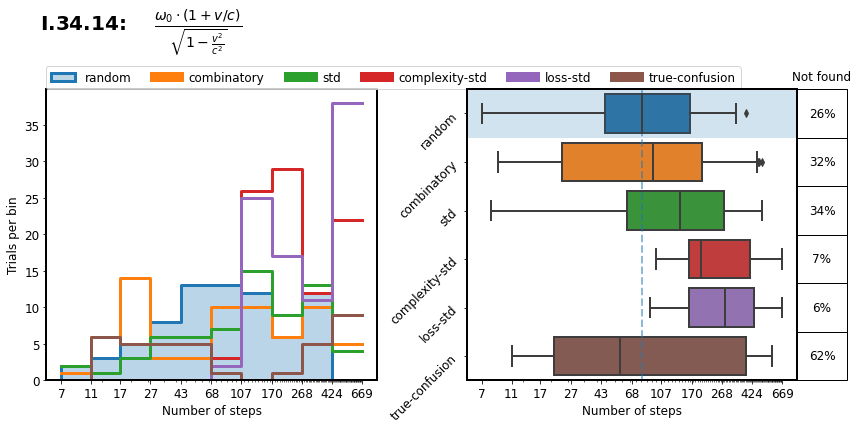

Plots saved in "plots.pdf"


In [56]:
# Set to True to save the plots as a pdf
save_as_pdf = False

# Define the number of bins
num_bins = 10
offset = 10

# copy the dataframe
summary_df_copy = summary_df.copy()
# add a column with the equation latex formulas from the feynman.csv file. use sympy to convert the string to latex
# load the feynman.csv file



def plot_hist_and_boxplot(pdf=None, log_scale=False):
    """Plot histogram with KDE for each equation and algorithm on the left, and a boxplot on the right"""

    for j, equation in enumerate(summary_df.index):
        # DEBUG
        if j > 8:
            break
        if j < 8:
            continue

        # Find the bin edges with the highest count
        max_bin_edges = None
        max_bin_count = 0

        _min = 500
        _max = 0

        for column in summary_df.columns[:-1]: # skip the last column, which is the formula
            # # account for log scale
            # bin_edges = np.histogram_bin_edges(summary_df.loc[equation, column])
            # print(bin_edges, len(bin_edges))
            # bin_counts = np.histogram(summary_df.loc[equation, column], bins=bin_edges)[0]
            # # Find the bin edges with the highest count
            # max_count = np.max(bin_counts)
            # print(max_count)
            # if max_count > max_bin_count:
            #     max_bin_count = max_count
            #     max_bin_edges = bin_edges
            # find min and max of the data
            _min = min(_min, np.nanmin(summary_df.loc[equation, column]))
            _max = max(_max, np.nanmax(summary_df.loc[equation, column]))
        
        # create bin edges with log scale
        if log_scale:
            bin_edges = np.logspace(np.log10(_min), np.log10(_max), num_bins+1, dtype=int)
        else:
            bin_edges = np.linspace(_min, _max, num_bins+1, dtype=int)
        
            
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        palette = sns.color_palette("tab10", len(ALGORITHMS))
        try:
            for i, column in enumerate(summary_df.columns[:-1]):
                # Use `bins` parameter to set the number of bins
                sns.histplot(summary_df.loc[equation, column], log_scale=False, bins=bin_edges, ax=ax[0], label=column, fill=(column=="random"), linewidth=3, element="step", color=palette[i], alpha=(0.3 if column=="random" else 1))
            # Plot the boxplot with the algorithm names on the x-axis
            sns.boxplot(data=summary_df.loc[equation].iloc[:-1], orient="h", ax=ax[1], showfliers=True, linewidth=2, palette=palette)
            # add a line for the mean of the random algorithm
            # get color of the random algorithm (seaborn)
            random_color = sns.color_palette()[0]
            ax[1].axvline(np.nanmedian(summary_df.loc[equation, 'random']), color=random_color, linestyle='--', linewidth=2, alpha=0.5)
            # add a background color to the random algorithm
            ax[1].axhspan(-0.5, 0.5, facecolor=random_color, alpha=0.2)
            
            
        except Exception as e:
            print(f"Could not plot {equation}")
            print(e)
            continue
        # Add x-ticks to the boxplot
        ax[1].set_yticklabels(ALGORITHMS, rotation=45, horizontalalignment='right')

        #ax[0].set_title("Histogram")
        #ax[1].set_title("Boxplot")
        ax[0].set_xlabel("Number of steps")
        ax[0].set_ylabel("Trials per bin")
        ax[1].set_xlabel("Number of steps")

        #change the x-axis of the ax[0] to semilog
        if log_scale:
            ax[0].set_xscale('log')
            ax[1].set_xscale('log')
            # replace the x-ticks with the bin edges
            # make minor ticks between the bin edges
            minor_bin_edges = np.linspace(_min, _max, num_bins*10+1, dtype=int)
            ax[0].set_xticks(minor_bin_edges, minor=True)
            ax[0].set_xticklabels([], minor=True)
            ax[1].set_xticks(minor_bin_edges, minor=True)
            ax[1].set_xticklabels([], minor=True)
            
            
            ax[0].set_xticks(bin_edges, minor=False)
            ax[0].set_xticklabels(bin_edges, minor=False)
            ax[1].set_xticks(bin_edges, minor=False)
            ax[1].set_xticklabels(bin_edges, minor=False)


        # add a table to the plot with the number of nan values for each algorithm
        # create a table with the number of nan values for each algorithm
        nan_table = pd.DataFrame(index=ALGORITHMS, columns=["Not found"])#
        for column in summary_df.columns[:-1]:
            # in percentage
            nan_table.loc[column, "Not found"] = str(int(np.sum(np.isnan(summary_df.loc[equation, column])) / len(summary_df.loc[equation, column]) * 100)) + "%"

    
        # create the table
        table = ax[1].table(cellText=nan_table.values, loc='right', bbox=[1.0, 0.0, 0.15, 1.0], cellLoc='center')
        # set the font size of the table
        table.set_fontsize(12)
        # add text above the table
        ax[1].text(1.075, 1.02, "Not found", fontsize=12, transform=ax[1].transAxes, ha='center', va='bottom')
        
        fig.suptitle(equation+":    "+latex(sympify(summary_df.loc[equation, 'formula']), mul_symbol="dot", mode="inline", fold_frac_powers=True, parenthesize_super=True), fontsize=20, weight="bold", ha="left", x=0.05, y=0.98)
        # add padding below the title
        fig.tight_layout()
        # make the legend below the plot
        leg = ax[0].legend(loc='upper center', bbox_to_anchor=(1.05, 1.10), ncol=6, fancybox=True)
        for line in leg.get_lines():
            line.set_linewidth(10.0)
        
        if pdf:
            pdf.savefig(fig)
        else:
            plt.show()
        plt.close(fig)

        

    print('Plots saved in "plots.pdf"')


if save_as_pdf:
    with PdfPages(TEMP_DIR / 'plots.pdf') as pdf:
        plot_hist_and_boxplot(pdf=pdf, log_scale=True)
else:
    plot_hist_and_boxplot(log_scale=True)

In [ ]:
# ridge plot
for equation in summary_df.index:
    max_bin_edges = None
    max_bin_count = 0
    for column in summary_df.columns:
        bin_edges = np.histogram_bin_edges(summary_df.loc[equation, column], bins=15)
        bin_counts = np.histogram(summary_df.loc[equation, column], bins=bin_edges)[0]
        # Find the bin edges with the highest count
        max_count = np.max(bin_counts)
        if max_count > max_bin_count:
            max_bin_count = max_count
            max_bin_edges = bin_edges
    df = pd.DataFrame(columns=["Algorithm", "Steps"])
    for column in summary_df.columns:
        df.loc[len(df)] = [column, summary_df.loc[equation, column].tolist()]
    df = df.explode("Steps")
    palette = sns.color_palette("Set2", len(ALGORITHMS))
    g = sns.FacetGrid(df, row="Algorithm", aspect=8, height=1.2, palette=palette, hue="Algorithm")
    g.map_dataframe(sns.histplot, x="Steps", bins=max_bin_edges)
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .5, label, color='black', fontsize=13,
                ha="left", va="center", transform=ax.transAxes)
    g.map(label, "Algorithm")
    g.set_titles("")
    g.set(yticks=[], xlabel="Number of steps")
    g.despine(left=True)
    # remove y label
    g.set(ylabel="")
    plt.suptitle('Steps to convergence for each algorithm', y=0.98)
    plt.show()
    break # DEBUG
    

## Aggregated plot

In [ ]:
# plot all the equations in one boxplot.
# create a dataframe with the median number of steps for each equation and algorithm
# add to ALGORITHMS the column "not_found" which contains the number of nan values for each algorithm
median_df = pd.DataFrame(index=summary_df.index, columns=ALGORITHMS.append([f"{algorithm}_not_found" for algorithm in ALGORITHMS]), dtype=float)
for equation in summary_df.index:
    for column in summary_df.columns[:-1]:
        median_df.loc[equation, column] = np.nanmedian(summary_df.loc[equation, column])
        # count the number of nan values
        median_df.loc[equation, column+"_not_found"] = np.sum(np.isnan(summary_df.loc[equation, column]))

# make a boxplot and histogram for each algorithm
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
algorithms_df = median_df[["random", "combinatory", "std", "complexity-std", "loss-std", "true-confusion"]]
sns.boxplot(data=algorithms_df, ax=ax[0], palette=sns.color_palette(), linewidth=2, orient="h", a)
sns.histplot(data=algorithms_df, ax=ax[1], palette=sns.color_palette(), linewidth=2, element="step", fill=False, bins=10, kde=True, common_norm=False)
# title
ax.set_title("Median number of steps for each algorithm", fontsize=20, weight="bold")



: 